# Importing NN modules and data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import sys
sys.path.insert(0,"/content/drive/My Drive/Colab Notebooks/NeuralNetwork")

In [2]:
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import os
import torch.optim as optim


import numpy as np
import random
import copy
import pickle
import pandas as pd
import time

from library_model import layers as lay
from library_model import model_building as mb
from library_model import model_training as mt
from data import data_loading as dt
from data import text as txt

# Process Data

In [3]:
from torchvision import datasets, transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda

In [5]:
train_data = datasets.FashionMNIST(root = "data" , train = True, download = True, transform = ToTensor(), target_transform= Lambda( lambda y: torch.zeros(10, dtype= torch.float).scatter_(0,torch.tensor(y),value = 1)))
test_data = datasets.FashionMNIST(root = "data" , train = False, download = True, transform = ToTensor(), target_transform= Lambda( lambda y: torch.zeros(10, dtype= torch.float).scatter_(0,torch.tensor(y),value = 1)))

In [6]:
d = dt.Data()
d.train_dataloader = DataLoader( dataset= train_data, batch_size = 64, shuffle = True)
d.test_dataloader = DataLoader( dataset= test_data, batch_size = 64, shuffle = True)

In [7]:
x1, y1 = (next(iter(d.train_dataloader)))
x1.size(), y1.size()

(torch.Size([64, 1, 28, 28]), torch.Size([64, 10]))

In [8]:
batch_num = len(d.train_dataloader)
num_epochs = 5
batch_num

938

# Define Network State

In [9]:
state = lay.Network_state()
p = state.parameters
tr = state.training
p.dropout = 0.2
p.convlayers = [{"filter_dim" : int(5), "in_features": int(1), "out_features": int(10), "pooling": 2.}, {"filter_dim": int(5), "in_features": int(10), "out_features" : int(10), "pooling": 2.}]
p.linearlayers = [{"dim_in" : int(10*(4**2)), "dim_hid" : int(100), "bias_is_true" : True , "relu_is_true" : True}, {"dim_in" : int(100), "dim_hid" : int(10), "bias_is_true" : True, "relu_is_true" : False}]
tr.lr = .5
tr.batch_size = 64
tr.optimizer = "sgd"
tr.schedule = mb.learning_rate_cosine(1., batch_num*num_epochs, 0.05)

# Construct Model

In [10]:
model = mb.Convolutional(state).to(state.device)

In [11]:
opt, scheduler = mb.get_optimizer(state, model)
criterion = nn.CrossEntropyLoss().to(state.device)

# Train Model

In [12]:
train_fashion = mt.CNN_training(data = d, state = state, model = model, opt = opt, scheduler = scheduler, train_log=200, test_log=400)

In [13]:
#untrained network accuracy
train_fashion.evaluate()

0.0859375

Batch 200 | lr = 0.523 | time =  0.06 | train_loss  1.00
Batch 400 | lr = 0.516 | time =  0.06 | train_loss  0.62
Batch 600 | lr = 0.505 | time =  0.06 | train_loss  0.50
Batch 800 | lr = 0.490 | time =  0.08 | train_loss  0.45
Epoch: 0 | time: 25.52 -- test loss = 0.43 -- accuracy = 0.79

Batch 200 | lr = 0.456 | time =  0.06 | train_loss  0.46
Batch 400 | lr = 0.431 | time =  0.06 | train_loss  0.44
Batch 600 | lr = 0.404 | time =  0.06 | train_loss  0.38
Batch 800 | lr = 0.374 | time =  0.10 | train_loss  0.36
Epoch: 1 | time: 25.80 -- test loss = 0.37 -- accuracy = 0.81

Batch 200 | lr = 0.320 | time =  0.10 | train_loss  0.38
Batch 400 | lr = 0.287 | time =  0.06 | train_loss  0.39
Batch 600 | lr = 0.253 | time =  0.06 | train_loss  0.33
Batch 800 | lr = 0.220 | time =  0.06 | train_loss  0.31
Epoch: 2 | time: 27.84 -- test loss = 0.32 -- accuracy = 0.83

Batch 200 | lr = 0.167 | time =  0.10 | train_loss  0.34
Batch 400 | lr = 0.138 | time =  0.06 | train_loss  0.33
Batch 600 | l

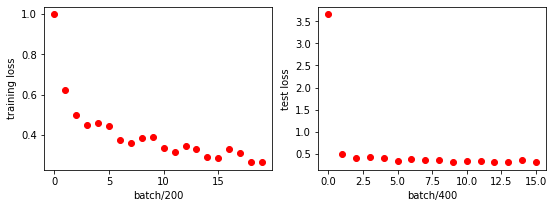

In [26]:
train_fashion(num_epochs)

# Cifar 10 - Loading dataset

In [14]:
transform2 = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size2 = 1000
train_data2 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform2, target_transform= Lambda( lambda y: torch.zeros(10, dtype= torch.float).scatter_(0,torch.tensor(y),value = 1)))

test_data2 = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform2, target_transform= Lambda( lambda y: torch.zeros(10, dtype= torch.float).scatter_(0,torch.tensor(y),value = 1)))

Files already downloaded and verified
Files already downloaded and verified


In [15]:
d2 = dt.Data()
d2.train_dataloader = DataLoader(train_data2, batch_size=batch_size2,
                                          shuffle=True)
d2.test_dataloader = DataLoader(test_data2, batch_size=batch_size2,
                                          shuffle=True)

In [16]:
x,y = next(iter(d2.train_dataloader))

In [17]:
def imshow(*images):
  plt.figure(figsize= (9,5))
  for k,img in enumerate(images): 
    plt.subplot(len(images)//4+1,4,k+1)
    npimg= img.numpy()
    npimg = (npimg/2 + 0.5).transpose(1,2,0)
    plt.imshow(npimg)
    plt.axis("off")

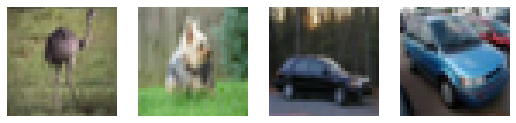

In [18]:
imshow(x[0], x[1], x[2], x[3])

In [19]:
batch_num2 = len(d2.train_dataloader)
num_epochs2 = 8
batch_num2

50

In [20]:
state2 = lay.Network_state()
p2 = state2.parameters
tr2 = state2.training
p2.dropout = 0.2
p2.convlayers = [{"filter_dim" : int(3), "in_features": int(3), "out_features": int(5), "pooling": 1.}, {"filter_dim": int(3), "in_features": int(5), "out_features" : int(5), "pooling": 2.}]
p2.linearlayers = [{"dim_in" : int(5*(14**2)), "dim_hid" : int(500), "bias_is_true" : True , "relu_is_true" : True}, {"dim_in" : int(500), "dim_hid" : int(10), "bias_is_true" : True, "relu_is_true" : False}]
tr2.lr = 1.
tr2.batch_size = 1000
tr2.optimizer = "sgd"
tr2.schedule = mb.learning_rate_cosine(2., batch_num2*num_epochs2, 0.2)

In [21]:
model2 = mb.Convolutional(state2).to(state2.device)

In [22]:
opt2, scheduler2 = mb.get_optimizer(state2, model2)
criterion2 = nn.CrossEntropyLoss().to(state2.device)

# Train Cifar-10

In [23]:
model2.state_dict().keys()

odict_keys(['convlayers.0.filter.weight', 'convlayers.0.filter.bias', 'convlayers.1.filter.weight', 'convlayers.1.filter.bias', 'linearlayers.0.weight', 'linearlayers.0.bias', 'linearlayers.1.weight', 'linearlayers.1.bias'])

In [24]:
param_logs2 ={'convlayers.0.filter.weight' : 15, 'convlayers.1.filter.weight' : 15, 'linearlayers.0.weight' : 15, 'linearlayers.1.weight' : 15}
records2 = mt.Records_class(**param_logs2)

In [25]:
train_cifar = mt.CNN_training(data = d2, state = state2, model = model2, opt = opt2, scheduler = scheduler2, train_log=15, test_log=25, records = records2)

Batch 15 | lr = 2.194 | time =  0.47 | train_loss  4.77
Batch 30 | lr = 2.174 | time =  0.47 | train_loss  3.07
Batch 45 | lr = 2.141 | time =  0.55 | train_loss  2.59
Epoch: 0 | time: 28.53 -- test loss = 2.16 -- accuracy = 0.15

Batch 15 | lr = 2.076 | time =  0.47 | train_loss  2.35
Batch 30 | lr = 2.014 | time =  0.56 | train_loss  2.12
Batch 45 | lr = 1.940 | time =  0.47 | train_loss  2.01
Epoch: 1 | time: 30.07 -- test loss = 1.70 -- accuracy = 0.30

Batch 15 | lr = 1.826 | time =  0.48 | train_loss  1.84
Batch 30 | lr = 1.730 | time =  0.48 | train_loss  1.73
Batch 45 | lr = 1.626 | time =  0.55 | train_loss  1.68
Epoch: 2 | time: 28.56 -- test loss = 1.38 -- accuracy = 0.43

Batch 15 | lr = 1.480 | time =  0.47 | train_loss  1.50
Batch 30 | lr = 1.365 | time =  0.55 | train_loss  1.48
Batch 45 | lr = 1.248 | time =  0.48 | train_loss  1.39
Epoch: 3 | time: 28.62 -- test loss = 1.27 -- accuracy = 0.47

Batch 15 | lr = 1.091 | time =  0.46 | train_loss  1.32
Batch 30 | lr = 0.97

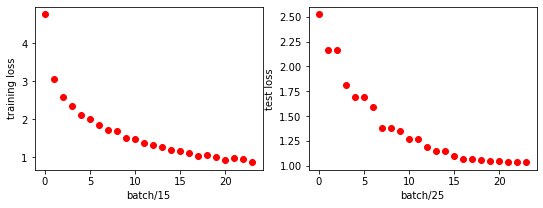

In [26]:
train_cifar(num_epochs2)

Text(0, 0.5, 'accuracy')

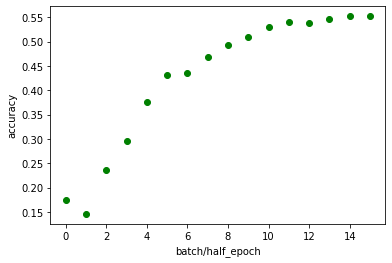

In [160]:
plt.plot(train_cifar.accuracy, "go")
plt.xlabel("batch/half_epoch")
plt.ylabel("accuracy")

# Visualizing weights during training

In [178]:
conv0norm = list(map(lambda x : x.view(-1).pow(2).sum().sqrt().to("cpu"), records2.parameters['convlayers.0.filter.weight']))
conv1norm = list(map(lambda x : x.view(-1).pow(2).sum().sqrt().to("cpu"), records2.parameters['convlayers.1.filter.weight']))
linear0norm = list(map(lambda x : x.view(-1).pow(2).sum().sqrt().to("cpu"), records2.parameters['linearlayers.0.weight']))
linear1norm = list(map(lambda x : x.view(-1).pow(2).sum().sqrt().to("cpu"), records2.parameters['linearlayers.1.weight']))

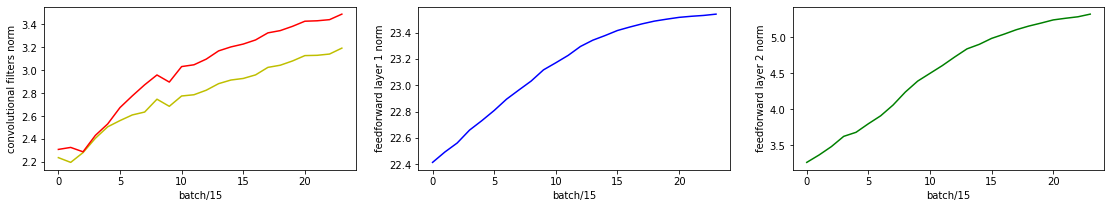

In [179]:
plt.figure(figsize=(19,3))
plt.subplot(1,3,1)
plt.plot(conv0norm, "y-", conv1norm, "r-")
plt.xlabel("batch/15")
plt.ylabel("convolutional filters norm")

plt.subplot(1,3,2)
plt.plot(linear0norm, "b-")
plt.xlabel("batch/15")
plt.ylabel("feedforward layer 1 norm")


plt.subplot(1,3,3)
plt.plot(linear1norm, "g-")
plt.xlabel("batch/15")
plt.ylabel("feedforward layer 2 norm")
plt.show()

In [180]:
def process_weights(*args):
  new_ws = []
  for w in args:
    wprime = (w-w.mean())/(2*w.std())
    wprime= wprime.masked_fill(wprime>0.5, 0.5).masked_fill(wprime<-0.5, -0.5) +0.5
    new_ws.append(wprime.to("cpu"))
  return new_ws


def weight_visualize(*parameters):
  plt.figure(figsize= (15,25))
  for k,img in enumerate(parameters): 
    plt.subplot(len(parameters)//4+1,4,k+1)
    npimg= img.numpy()
    plt.imshow(npimg)
    plt.axis("off")

In [181]:
params_t= []
for step in range(0,len(list(records2.parameters.values())[0]),4):
  params_t = params_t+ list(map(lambda x : torch.tensordot(x[step],x[step], dims= ([-1],[-1])), records2.parameters.values()))
visual_params = process_weights(*params_t)

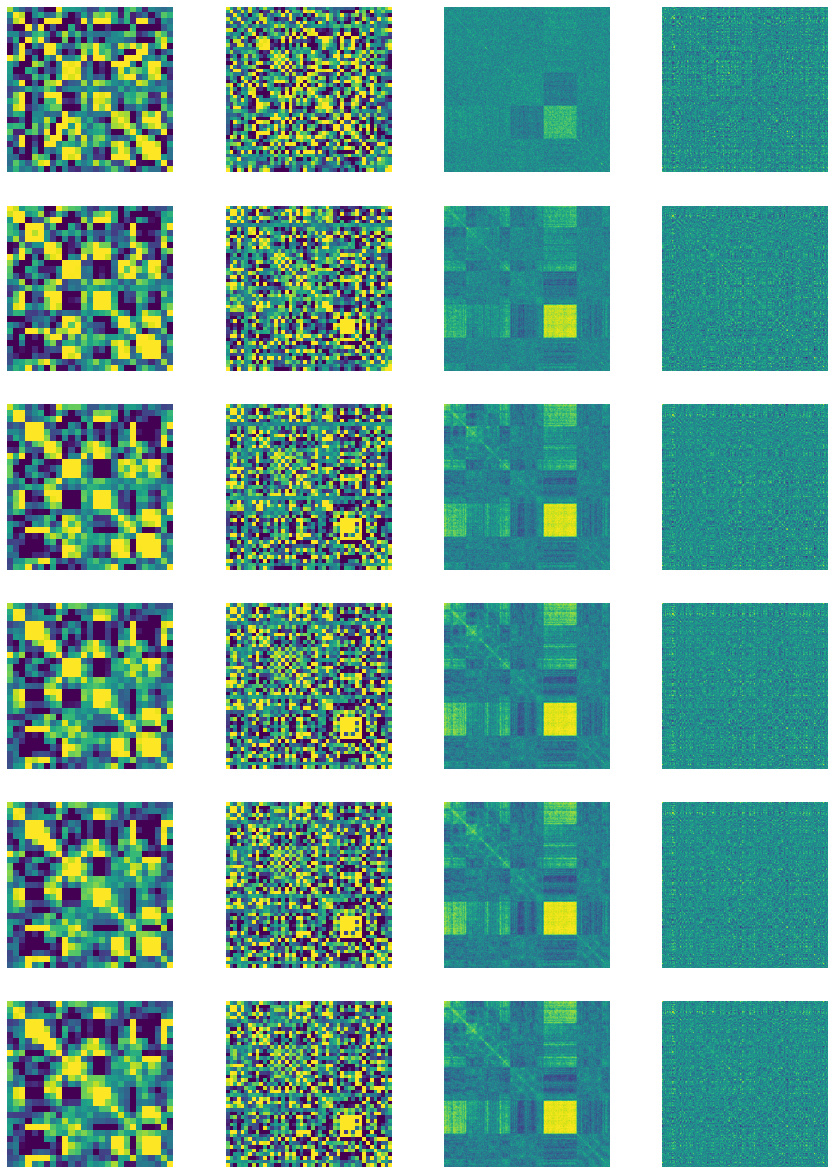

In [182]:
weight_visualize(*visual_params)
# (conv1, conv2, FF1, FF2)
# each row correspons to a different training time